# Evolutionary computing: lab3

Lab 3 - Travelling salesman problem.
The final lab will be to solve classic travelling salesman problem that is discrete combinatoric problem.
Try to use the same framework DEAP to do it with similar structure as for first two labs (not strongly required). 
The task:
Get the data from this site (only XQF 131 problem):
http://www.math.uwaterloo.ca/tsp/vlsi/index.html
You have to download the dataset with points (131 cities). This data should be uploaded into your script to evaluate distance matrix between cities. After that you have to design a Genetic Algorithm (or another one as you wish).
As a result, I would like to see the plot with obtained evolution results (best route distance at each iteration of algorithm) and the final route as the picture.
As you can find out, the best optimal route length is 564) I would like to see from your solution < 800 as good result.
The best route with 564 length.


# Environment preparations

In [ ]:
import array
import random
import json
import re
import numpy

import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

In [ ]:
!pip install deap

     |████████████████████████████████| 160 kB 5.1 MB/s 


# Data preparations

In [ ]:
with open('xqf131.tsp') as f:
  content = f.readlines()

In [ ]:
x = list()
y = list()
coordinates_dict = dict()
for line in content[8:-1]:
  coords = re.split('\s', line)
  # change numeration to start with zero
  coordinates_dict[int(coords[0]) - 1] = (int(coords[1]), int(coords[2]))
  x.append(int(coords[1]))
  y.append(int(coords[2]))

In [ ]:
CITIES_NUM = 131

In [ ]:
assert len(y)==len(x) and len(x)==CITIES_NUM, 'Data length is incorrect'

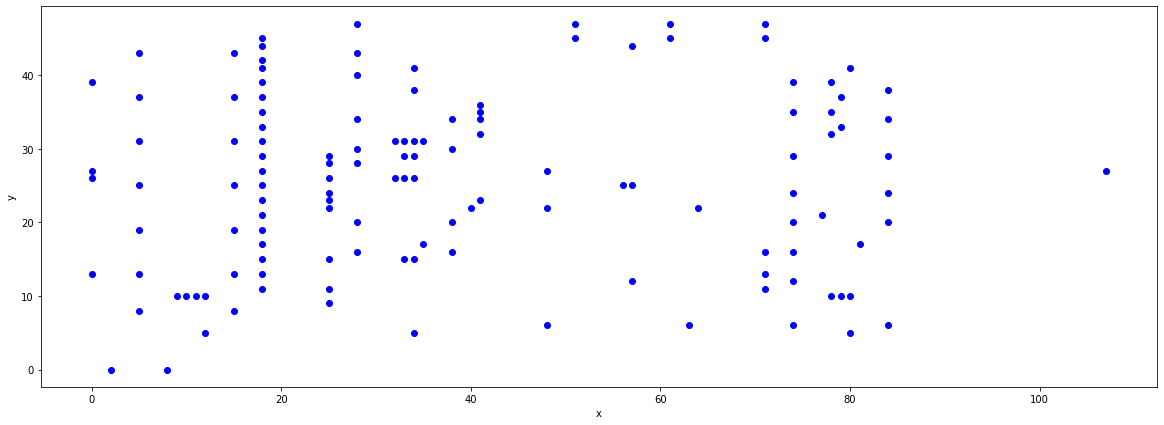

In [ ]:
plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.scatter(x, y, c='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# Travelling salesman problem

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

In [ ]:
def euc_2d_dist(point1, point2):
  x1, y1 = point1
  x2, y2 = point2
  return ((((x2 - x1 ) ** 2) + ((y2-y1) ** 2)) ** 0.5)

In [ ]:
def eval_cities(individual):
    distance = euc_2d_dist(coordinates_dict[individual[-1]], coordinates_dict[individual[0]])
    for city1, city2 in zip(individual[0:-1], individual[1:]):
        distance += euc_2d_dist(coordinates_dict[city1], coordinates_dict[city2])
    return distance,

In [ ]:
def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)

def draw_log(log):
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg")
    plt.plot(gen_list, min_list, label="min")
    plt.plot(gen_list, max_list, label="max")
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

def draw_logs(log1, log2, lab1, lab2):
    gen1, avg1, std1, max1, min1 = read_log(log1)
    gen2, avg2, std2, max2, min2 = read_log(log2)
    plt.plot(gen1, avg1, label=lab1, color="blue")
    plt.plot(gen1, max1, label="{}_max".format(lab1), color="blue", linewidth=2)
    plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
    plt.plot(gen2, avg2, label=lab2, color="orange")
    plt.plot(gen2, max2, label="{}_max".format(lab2), color="orange", linewidth=2)
    plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def varOr(population, toolbox, lambda_, cxpb, mutpb, start_indpb):
    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = list(map(toolbox.clone, random.sample(population, 2)))
            ind1 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            offspring.append(ind1)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind, start_indpb)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(toolbox.clone(random.choice(population)))

    return offspring


def eaMuPlusLambda(population, toolbox, start_indpb, mu, lambda_, cxpb, mutpb, ngen,
                   stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Increase mutation probability in time
        if gen % 200 == 0:
          start_indpb += 0.0005
          mutpb += 0.05
          cxpb -= 0.05

          print('new start_indpb', start_indpb)
        # Vary the population
        if halloffame is not None:
            for ind in halloffame:
                population.append(toolbox.clone(ind))
        offspring = varOr(population, toolbox, lambda_, cxpb, mutpb, start_indpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


In [ ]:
toolbox = base.Toolbox()

# Attribute generator
toolbox.register("indices", random.sample, range(CITIES_NUM), CITIES_NUM)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
def eval_list_cities(cities):
    distance = euc_2d_dist(coordinates_dict[cities[-1]], coordinates_dict[cities[0]])
    for city1, city2 in zip(cities[0:-1], cities[1:]):
        distance += euc_2d_dist(coordinates_dict[city1], coordinates_dict[city2])
    return distance

In [ ]:
def mate_func(p1, p2):

  # we try to inherit only "good" features of parent
  tries = 100
  for _ in range(tries):
    start_gene = int(random.random()*len(p1))
    end_gene = int(random.random()*len(p1))
    if start_gene == end_gene:
      continue
    part1 = list()
    temp = list()
    for i in range(min(start_gene, end_gene), max(start_gene, end_gene)):
      part1.append(p2[i])
      temp.append(p1[i])
    if eval_list_cities(temp) < eval_list_cities(part1):
      break

  # do not repeat the same cities
  part2 = [gene for gene in p2 if gene not in part1]
  new_genes = part1+part2

  for i in range(len(p1)):
    p1[i] = new_genes[i]

  return p1

In [ ]:
def mutate(ind, indpb=0.01):
  for gene in range(len(ind)):
    if random.random() < indpb:
      old_gene = ind[gene]
      id_replace = int(random.random()*len(ind))
      ind[gene] = ind[id_replace]
      ind[id_replace] = old_gene
  return ind,

In [ ]:
POP_SIZE = 50
ITER_NUM = 2000
BEST_IND_NUM = 10
MUT_PROB= 0.5
CXPB = 0.45
START_INDPB = 0.005
#04, 06

In [ ]:
toolbox.register("mate", mate_func)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize = 3)
toolbox.register("evaluate", eval_cities)

In [ ]:
pop = toolbox.population(n=POP_SIZE)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

Start simulations

In [ ]:
pop, log = eaMuPlusLambda(pop, toolbox, mu = POP_SIZE, lambda_=int(POP_SIZE), cxpb=CXPB, mutpb=MUT_PROB,
                        start_indpb=START_INDPB, ngen=ITER_NUM, halloffame=hof, stats=stats, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	50    	4672.98	190.298	4205.49	5281.17
1  	48    	4458.34	119.859	4176.28	4632.97
2  	49    	4367.49	111.861	4159.97	4516.42
3  	46    	4256.89	104.831	4139.24	4425.08
4  	45    	4182.72	55.9114	4133.27	4392.24
5  	48    	4152.92	27.0043	4133.27	4294.5 
6  	45    	4131.74	16.7392	4070.87	4159.97
7  	45    	4110.85	26.1962	4070.87	4138.63
8  	49    	4085.1 	20.982 	4033.66	4133.27
9  	49    	4059.4 	42.7347	3922.94	4128.48
10 	47    	4006.91	60.6477	3922.94	4074.24
11 	45    	3965.64	47.9703	3914.1 	4070.87
12 	43    	3929.26	21.0723	3891.27	4012.04
13 	47    	3915.85	17.0592	3868.95	3960.99
14 	49    	3899.04	23.5261	3849.75	3965.09
15 	44    	3877.08	28.0299	3828.72	3920.09
16 	49    	3850.6 	23.1411	3786.19	3909.38
17 	49    	3820.85	34.3996	3734.14	3860.96
18 	48    	3788.67	35.9058	3734.14	3837.9 
19 	44    	3764.51	31.2645	3715.23	3837.9 
20 	47    	3739.01	16.7149	3706.41	3773.82
21 	47    	3718.07	28.9057	3614.13	3762.23
22 	45    	

Obtained results at each step of evolution: we have increased the probability of mutation, thus we have larger range closer to the end of simulation

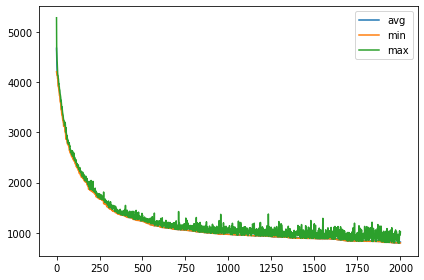

In [ ]:
draw_log(log)

Best route trajectory:

In [ ]:
best = hof[0]
best

Individual('i', [56, 57, 58, 72, 71, 79, 85, 84, 82, 78, 77, 80, 81, 87, 86, 91, 93, 98, 92, 101, 105, 106, 119, 116, 121, 128, 127, 115, 118, 114, 130, 124, 112, 107, 108, 109, 126, 125, 123, 120, 104, 100, 99, 113, 117, 122, 129, 111, 97, 88, 76, 67, 74, 63, 73, 44, 52, 53, 45, 6, 5, 0, 1, 2, 3, 9, 10, 37, 36, 32, 31, 19, 18, 25, 26, 27, 24, 16, 15, 13, 14, 17, 12, 4, 11, 28, 29, 30, 20, 7, 8, 21, 34, 33, 51, 55, 50, 48, 47, 54, 46, 49, 35, 41, 42, 43, 23, 22, 38, 39, 40, 59, 60, 94, 95, 110, 102, 103, 96, 90, 89, 83, 75, 62, 66, 70, 65, 69, 68, 64, 61])

In [ ]:
print('Best trajectory length:', eval_cities(best))

Best trajectory length: (799.6753270244081,)


In [ ]:
trajectory = []
for city in best:
  trajectory.append([x[city], y[city]])
trajectory = np.array(trajectory)

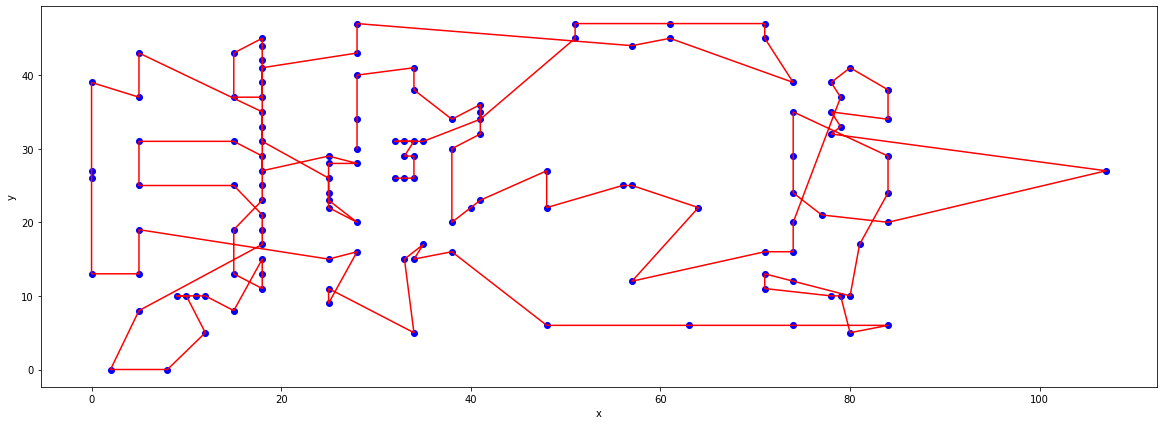

In [ ]:
plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.scatter(x, y, c='blue')
plt.plot(trajectory.T[0], trajectory.T[1], color = 'red')

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()